In [1]:
!pip install "pandas<2.0.0"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import coo_matrix
import pickle

from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/CSE512/HW5'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/CSE512/HW5


In [4]:

## Load and preprocess data, remove all users/movies from test data that do not appear in train data
#look but don't touch.
"""
import copy

#ratings_df = pd.read_csv('ml-latest/ratings.csv')
ratings_test_df = pd.read_csv('ml-latest-small/ratings.csv')
print(ratings_test_df.shape)
ratings_df = ratings_test_df.sample(frac=0.33)
ratings_test_df = ratings_test_df.drop(ratings_df.index)
ratings_val_df = ratings_test_df.sample(frac=0.50)
ratings_test_df = ratings_test_df.drop(ratings_val_df.index)
print(ratings_df.shape,ratings_val_df.shape,ratings_test_df.shape)

#hash everything
user_idx = np.unique(ratings_df['userId'])
movie_idx = np.unique(ratings_df['movieId'])

ratings_df_new = copy.deepcopy(ratings_df)
ratings_val_df_new = copy.deepcopy(ratings_val_df)
ratings_test_df_new = copy.deepcopy(ratings_test_df)
for i in range(len(user_idx)):
    ratings_df_new.loc[ratings_df['userId']==user_idx[i], 'userId'] = i
    ratings_val_df_new.loc[ratings_val_df['userId']==user_idx[i], 'userId'] = i
    ratings_test_df_new.loc[ratings_test_df['userId']==user_idx[i], 'userId'] = i
for j in range(len(movie_idx)):
    ratings_df_new.loc[ratings_df['movieId']==movie_idx[j], 'movieId'] = j
    ratings_val_df_new.loc[ratings_val_df['movieId']==movie_idx[j], 'movieId'] = j
    ratings_test_df_new.loc[ratings_test_df['movieId']==movie_idx[j], 'movieId'] = j



pickle.dump({'ratings_df':ratings_df_new,'ratings_val_df':ratings_val_df_new,'ratings_test_df':ratings_test_df_new},open('movie_tables.pkl','wb'))
"""

"\nimport copy\n\n#ratings_df = pd.read_csv('ml-latest/ratings.csv')\nratings_test_df = pd.read_csv('ml-latest-small/ratings.csv')\nprint(ratings_test_df.shape)\nratings_df = ratings_test_df.sample(frac=0.33)\nratings_test_df = ratings_test_df.drop(ratings_df.index)\nratings_val_df = ratings_test_df.sample(frac=0.50)\nratings_test_df = ratings_test_df.drop(ratings_val_df.index)\nprint(ratings_df.shape,ratings_val_df.shape,ratings_test_df.shape)\n\n#hash everything\nuser_idx = np.unique(ratings_df['userId'])\nmovie_idx = np.unique(ratings_df['movieId'])\n\nratings_df_new = copy.deepcopy(ratings_df)\nratings_val_df_new = copy.deepcopy(ratings_val_df)\nratings_test_df_new = copy.deepcopy(ratings_test_df)\nfor i in range(len(user_idx)):\n    ratings_df_new.loc[ratings_df['userId']==user_idx[i], 'userId'] = i\n    ratings_val_df_new.loc[ratings_val_df['userId']==user_idx[i], 'userId'] = i\n    ratings_test_df_new.loc[ratings_test_df['userId']==user_idx[i], 'userId'] = i\nfor j in range(len(

In [2]:
data = pickle.load(open('movie_tables.pkl','rb'))
ratings_df = data['ratings_df']
ratings_val_df = data['ratings_val_df']
ratings_test_df = data['ratings_test_df']
R = coo_matrix((ratings_df['rating'], (ratings_df['userId'],ratings_df['movieId'])))

print(R.shape, len(np.unique(R.row)), len(np.unique(R.col)))

(610, 6381) 610 6381


In [5]:
#write a function that, given a list of uIDs and mIDs, returns the global average of the train set
global_avg = np.mean(ratings_df['rating'])
def predictor(uID,mID):
    return global_avg*np.ones(len(uID)) # global average


# fill in the RMSE functions, using the predictor as input.
def compute_rmse(data, predictor):
    uIDs = data['userId'].values
    mIDs = data['movieId'].values
    true_ratings = data['rating'].values
    predicted_ratings = predictor(uIDs, mIDs)
    return np.sqrt(np.mean((true_ratings - predicted_ratings) ** 2))
def get_rmse_train(predictor):
    return compute_rmse(ratings_df, predictor)
def get_rmse_val(predictor):
    return compute_rmse(ratings_val_df, predictor)
def get_rmse_test(predictor):
    return compute_rmse(ratings_test_df, predictor)

In [6]:
train_rmse = get_rmse_train(predictor)
val_rmse = get_rmse_val(predictor)
test_rmse = get_rmse_test(predictor)

print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 1.0453378956423331, Validation RMSE: 1.0384954134276096, Test RMSE: 1.043776737697598


In [8]:
user_avg = ratings_df.groupby('userId')['rating'].mean() - global_avg

def user_avg_predictor(uID, mID):
    predictions = []
    for user in uID:
        predictions.append(global_avg + user_avg.get(user, 0))
    return np.array(predictions)

movie_avg = ratings_df.groupby('movieId')['rating'].mean() - global_avg

def movie_avg_predictor(uID, mID):
    predictions = []
    for movie in mID:
        predictions.append(global_avg + movie_avg.get(movie, 0))
    return np.array(predictions)

train_rmse_user = get_rmse_train(user_avg_predictor)
val_rmse_user = get_rmse_val(user_avg_predictor)
test_rmse_user = get_rmse_test(user_avg_predictor)
print(f"Train RMSE User: {train_rmse_user}, Validation RMSE User: {val_rmse_user}, Test RMSE User: {test_rmse_user}")

train_rmse_movie = get_rmse_train(movie_avg_predictor)
val_rmse_movie = get_rmse_val(movie_avg_predictor)
test_rmse_movie = get_rmse_test(movie_avg_predictor)
print(f"Train RMSE Movie: {train_rmse_movie}, Validation RMSE Movie: {val_rmse_movie}, Test RMSE Movie: {test_rmse_movie}")

Train RMSE User: 0.9303541467440325, Validation RMSE User: 0.9453702230795641, Test RMSE User: 0.9506944370582363
Train RMSE Movie: 0.8298431428616648, Validation RMSE Movie: 1.018877291556982, Test RMSE Movie: 1.026990470728207


In [9]:
def combined_predictor(uID, mID):
    predictions = []
    for user, movie in zip(uID, mID):
        predictions.append(global_avg + 0.5 * user_avg.get(user, 0) + 0.5 * movie_avg.get(movie, 0))
    return np.array(predictions)

train_rmse_combined = get_rmse_train(combined_predictor)
val_rmse_combined = get_rmse_val(combined_predictor)
test_rmse_combined = get_rmse_test(combined_predictor)
print(f"Train RMSE Combine: {train_rmse_combined}, Validation RMSE Combine: {val_rmse_combined}, Test RMSE Combine: {test_rmse_combined}")

Train RMSE Combine: 0.8125245349156025, Validation RMSE Combine: 0.9139580565016393, Test RMSE Combine: 0.9201928948677766


In [12]:
def get_grad_ui(U,V,i):
    j_nonzero = R.col[R.row == i]
    gradient = np.zeros(U.shape[1])
    for j in j_nonzero:
        r_ij = R.data[np.logical_and(R.row == i, R.col == j)][0]
        gradient += (np.dot(U[i], V[j]) + global_avg + 0.5 * movie_avg[j] + 0.5 * user_avg[i] - r_ij) * V[j]
    return gradient

def get_grad_vj(U,V,j):
    i_nonzero = R.row[R.col == j]
    gradient = np.zeros(V.shape[1])
    for i in i_nonzero:
        r_ij = R.data[np.logical_and(R.row == i, R.col == j)][0]
        gradient += (np.dot(U[i], V[j]) + global_avg + 0.5 * movie_avg[j] + 0.5 * user_avg[i] - r_ij) * U[i]
    return gradient

Iteration 1: Train RMSE = 0.8020, Validation RMSE = 0.9167, Test RMSE = 0.9236
Iteration 2: Train RMSE = 0.7841, Validation RMSE = 0.9190, Test RMSE = 0.9263
Iteration 3: Train RMSE = 0.7531, Validation RMSE = 0.9273, Test RMSE = 0.9348
Iteration 4: Train RMSE = 0.7117, Validation RMSE = 0.9443, Test RMSE = 0.9518
Iteration 5: Train RMSE = 0.6731, Validation RMSE = 0.9661, Test RMSE = 0.9726
Iteration 6: Train RMSE = 0.6420, Validation RMSE = 0.9852, Test RMSE = 0.9909
Iteration 7: Train RMSE = 0.6168, Validation RMSE = 1.0025, Test RMSE = 1.0074
Iteration 8: Train RMSE = 0.5971, Validation RMSE = 1.0170, Test RMSE = 1.0214
Iteration 9: Train RMSE = 0.5816, Validation RMSE = 1.0315, Test RMSE = 1.0350
Iteration 10: Train RMSE = 0.5685, Validation RMSE = 1.0415, Test RMSE = 1.0451
Iteration 11: Train RMSE = 0.5610, Validation RMSE = 1.0532, Test RMSE = 1.0561
Iteration 12: Train RMSE = 0.5605, Validation RMSE = 1.0646, Test RMSE = 1.0671
Iteration 13: Train RMSE = 0.5739, Validation RMS

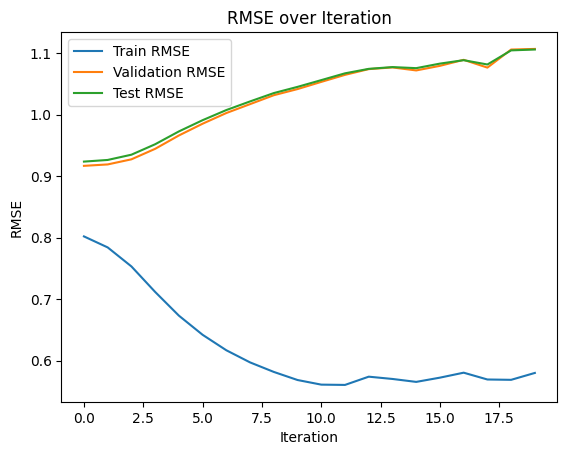

In [45]:
r = 5
step_size = 0.05
max_iter = 20
U = np.random.normal(0, 1/r, (R.shape[0], r))
V = np.random.normal(0, 1/r, (R.shape[1], r))
def predict(uID, mID):
    predictions = []
    for u, m in zip(uID, mID):
        user_vec = U[u] if u < U.shape[0] else np.zeros(U.shape[1])
        movie_vec = V[m] if m < V.shape[0] else np.zeros(V.shape[1])
        predictions.append(global_avg + 0.5 * user_avg.get(u, 0) + 0.5 * movie_avg.get(m, 0) + np.dot(user_vec, movie_vec))
    return np.array(predictions)

train_rmse_history = []
val_rmse_history = []
test_rmse_history = []
for it in range(max_iter):
    for i in range(U.shape[0]):
        U[i] -= step_size * get_grad_ui(U, V, i)
    for j in range(V.shape[0]):
        V[j] -= step_size * get_grad_vj(U, V, j)

    train_rmse = get_rmse_train(predict)
    val_rmse = get_rmse_val(predict)
    test_rmse = get_rmse_test(predict)
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    test_rmse_history.append(test_rmse)
    print(f"Iteration {it + 1}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

plt.plot(train_rmse_history, label="Train RMSE")
plt.plot(val_rmse_history, label="Validation RMSE")
plt.plot(test_rmse_history, label="Test RMSE")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE over Iteration")
plt.show()

Iteration 1: Train RMSE = 0.8224, Validation RMSE = 0.9253, Test RMSE = 0.9328
Iteration 2: Train RMSE = 0.8162, Validation RMSE = 0.9229, Test RMSE = 0.9303
Iteration 3: Train RMSE = 0.8118, Validation RMSE = 0.9217, Test RMSE = 0.9291
Iteration 4: Train RMSE = 0.8084, Validation RMSE = 0.9210, Test RMSE = 0.9285
Iteration 5: Train RMSE = 0.8055, Validation RMSE = 0.9207, Test RMSE = 0.9283
Iteration 6: Train RMSE = 0.8027, Validation RMSE = 0.9206, Test RMSE = 0.9283
Iteration 7: Train RMSE = 0.8002, Validation RMSE = 0.9207, Test RMSE = 0.9284
Iteration 8: Train RMSE = 0.7976, Validation RMSE = 0.9209, Test RMSE = 0.9288
Iteration 9: Train RMSE = 0.7950, Validation RMSE = 0.9213, Test RMSE = 0.9292
Iteration 10: Train RMSE = 0.7923, Validation RMSE = 0.9217, Test RMSE = 0.9298
Iteration 11: Train RMSE = 0.7896, Validation RMSE = 0.9223, Test RMSE = 0.9305
Iteration 12: Train RMSE = 0.7867, Validation RMSE = 0.9230, Test RMSE = 0.9313
Iteration 13: Train RMSE = 0.7837, Validation RMS

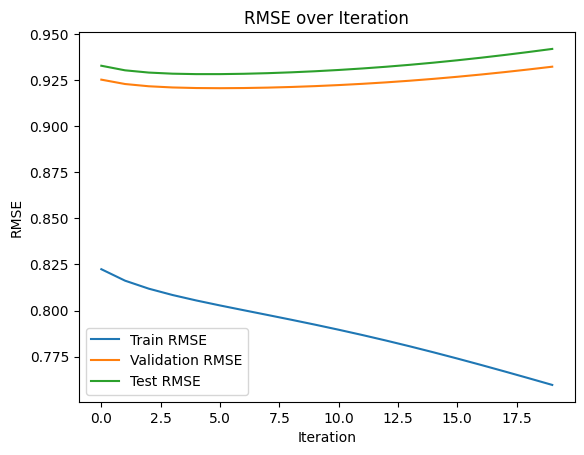

In [47]:
r = 3
step_size = 0.01
max_iter = 20
U = np.random.normal(0, 1/r, (R.shape[0], r))
V = np.random.normal(0, 1/r, (R.shape[1], r))
def predict(uID, mID):
    predictions = []
    for u, m in zip(uID, mID):
        user_vec = U[u] if u < U.shape[0] else np.zeros(U.shape[1])
        movie_vec = V[m] if m < V.shape[0] else np.zeros(V.shape[1])
        predictions.append(global_avg + 0.5 * user_avg.get(u, 0) + 0.5 * movie_avg.get(m, 0) + np.dot(user_vec, movie_vec))
    return np.array(predictions)

train_rmse_history = []
val_rmse_history = []
test_rmse_history = []
for it in range(max_iter):
    for i in range(U.shape[0]):
        U[i] -= step_size * get_grad_ui(U, V, i)
    for j in range(V.shape[0]):
        V[j] -= step_size * get_grad_vj(U, V, j)

    train_rmse = get_rmse_train(predict)
    val_rmse = get_rmse_val(predict)
    test_rmse = get_rmse_test(predict)
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    test_rmse_history.append(test_rmse)
    print(f"Iteration {it + 1}: Train RMSE = {train_rmse:.4f}, Validation RMSE = {val_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

plt.plot(train_rmse_history, label="Train RMSE")
plt.plot(val_rmse_history, label="Validation RMSE")
plt.plot(test_rmse_history, label="Test RMSE")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("RMSE over Iteration")
plt.show()